<a href="https://colab.research.google.com/github/pankajti/qtw/blob/master/Risk_GWP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [156]:

!pip install eia
!pip install fredapi
from IPython.display import clear_output
clear_output()

In [157]:
import matplotlib.pyplot as plt
from fredapi import Fred
import yfinance as yf
import pandas as pd
import numpy as np
import requests
import datetime
import eia

# Step 3

## Macroeconomic Data


In [158]:
macro_indicators = {"PAPR_NONOPEC":"Non-OPEC total liquid fuels production", "COPR_OPEC":"OPEC crude oil production"}
macro_data = {}
eia_key = r'KhUGeRcdKwP8WpygPCSDasWyaRburTqyE9er7aUN'
url_data = 'http://api.eia.gov/v2/seriesid/{}?api_key={}&out=json&start=2018-01'
for ind_key in macro_indicators.keys():
  series=f'STEO.{ind_key}.M'
  print(series)

  search = requests.get(url_data.format(series, eia_key))
  eia_data = pd.DataFrame(search.json().get('response').get('data'))
  eia_data=eia_data.set_index('period')
  eia_data.index = eia_data.index.map(lambda x:datetime.datetime.strptime(x[:9], "%Y-%m").date());
  eia_data.index = pd.to_datetime(eia_data.index);
  eia_data= eia_data[['value']]
  eia_data.columns = [series]
  # eia_data.replace('-', np.nan, regex=True, inplace=True);
  # eia_data.replace('No Data Reported', np.nan, regex=True, inplace=True);
  # eia_data.loc[eia_data[ series]=='No Data Reported']=np.NAN
  # eia_data.fillna(method='bfill', inplace=True);
  macro_data[ind_key]=eia_data

STEO.PAPR_NONOPEC.M
STEO.COPR_OPEC.M


(396, 1)


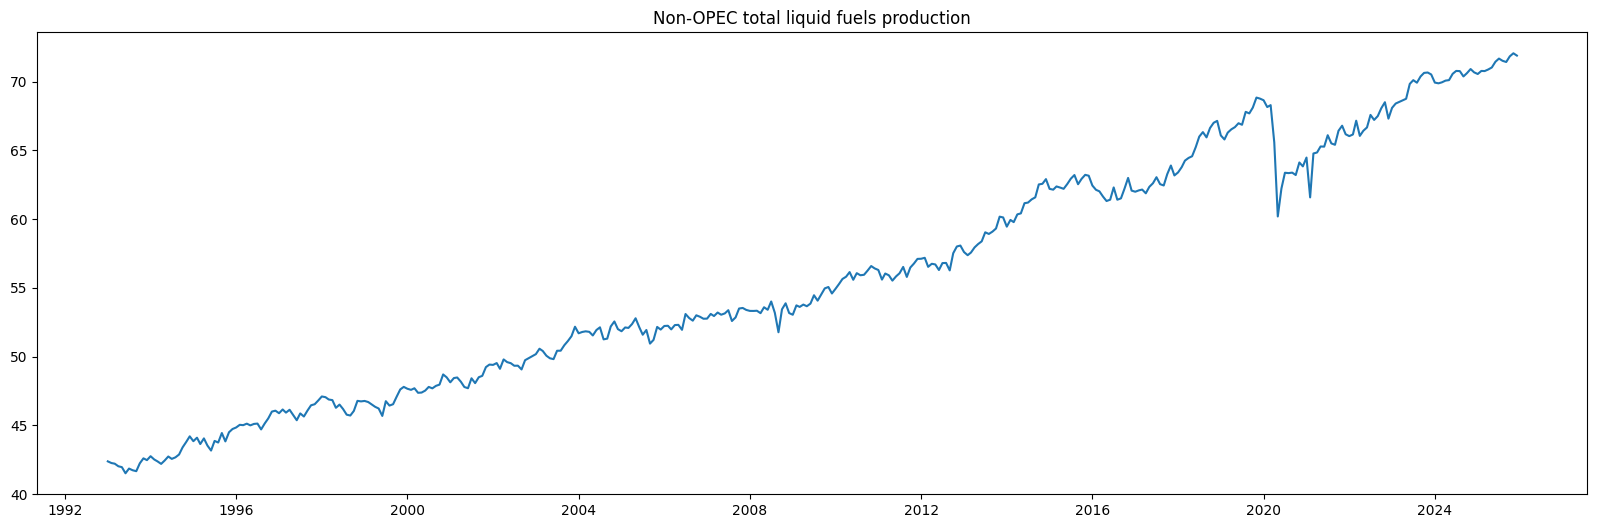

(396, 1)


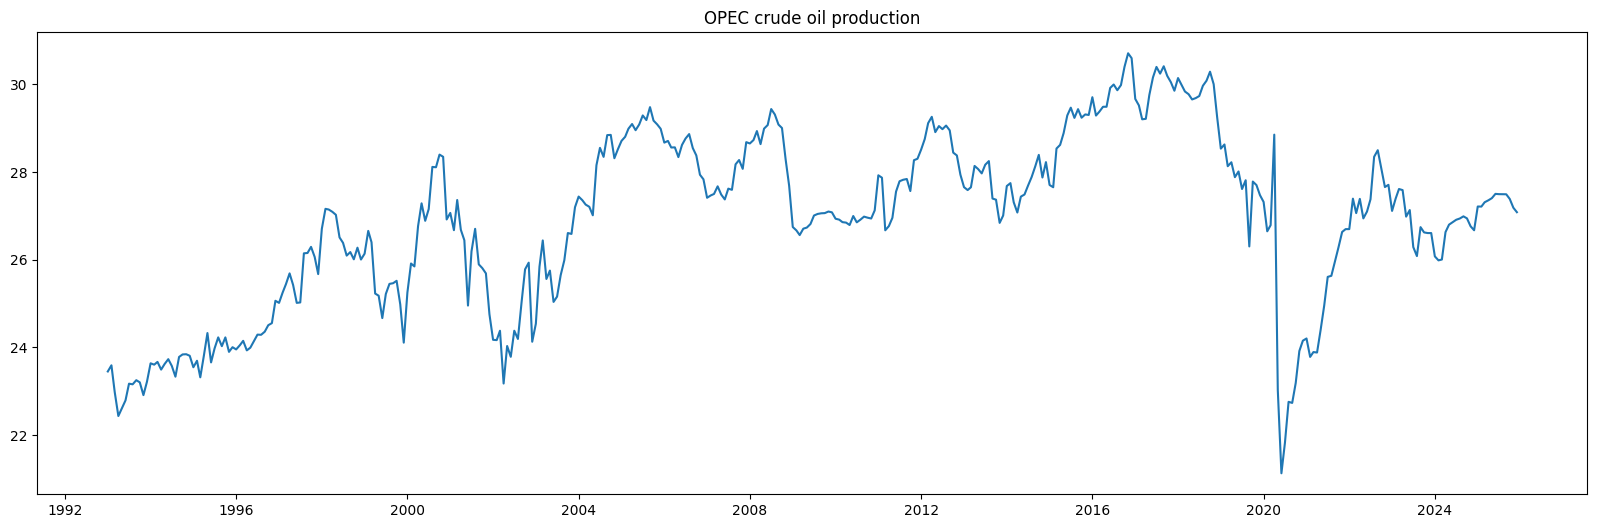

In [159]:
for ind_key,eia_data in macro_data.items():
  print(eia_data.shape)
  #print(len(eia_data.loc[eia_data[series]=='No Data Reported']))
  fig, ax = plt.subplots(figsize=(20,6));
  ax.set_title(macro_indicators[ind_key])
  ax.plot(eia_data)
  plt.show()

In [160]:
def clean_EIA(data):
    data.replace('-', np.nan, regex=True, inplace=True);
    data.fillna(method='bfill', inplace=True);
    data.index = data.index.map(lambda x:datetime.datetime.strptime(x[:9], "%Y-%m").date());
    data.index = pd.to_datetime(data.index);

## Microeconomics Data

* Analysis of microeconomic data
* Production
* Oil Stock
* Oil Imports
* Price of crude oil

In [161]:
api_dict = {"import_url":"https://api.eia.gov/v2/crude-oil-imports/data/?frequency=monthly&data[0]=quantity&facets[originType][]=WORLD&start=2018-01&facets[destinationType][]=US&facets[destinationId][]=US&facets[gradeId][]=MED&facets[originId][]=WORLD&start=2018-01&end=2023-10&sort[0][column]=period&sort[0][direction]=asc&offset=0&length=5000",
            "prod_api_url" : "https://api.eia.gov/v2/petroleum/crd/crpdn/data/?frequency=monthly&data[0]=value&start=2018-01&sort[0][column]=period&sort[0][direction]=asc&offset=0&length=5000",
            "stock_data_url" : r'https://api.eia.gov/v2/petroleum/stoc/cu/data/?frequency=monthly&data[0]=value&start=2018-01&facets[product][]=EPC0&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key={}'.format(eia_key)

}
api_key = 'eUHpyXZoiSdhtoFkoVXZa3xhG6YUY2w1fJxpVUlI'


In [162]:
micro_data = {}
for key in api_dict:
  api_url=api_dict[key]
  api_url_with_key = f"{api_url}&api_key={api_key}"
  response = requests.get(api_url_with_key)
  # Check if the response was successful
  if response.status_code == 200:
      data = response.json()
      data_list = data.get('response', {}).get('data', [])
      df = pd.DataFrame(data_list)
      #print(df.head(4))
  else:
      print(f"Error fetching data: {response.status_code}")
      df = pd.DataFrame()
  micro_data[key] = df

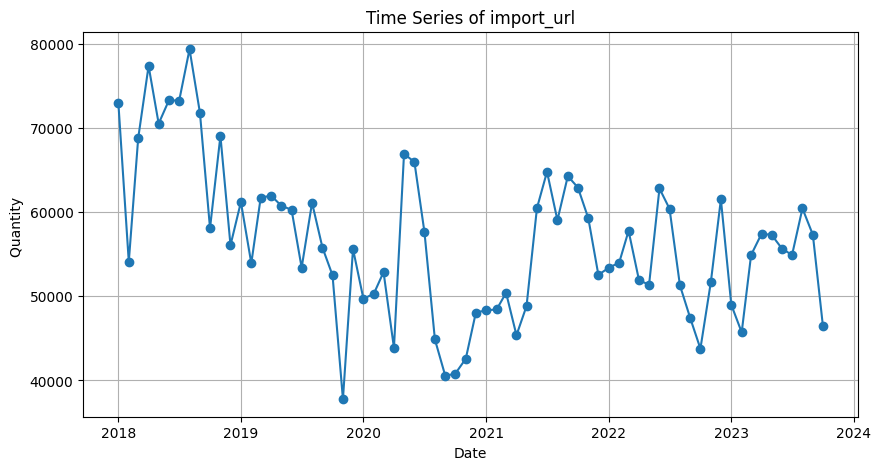

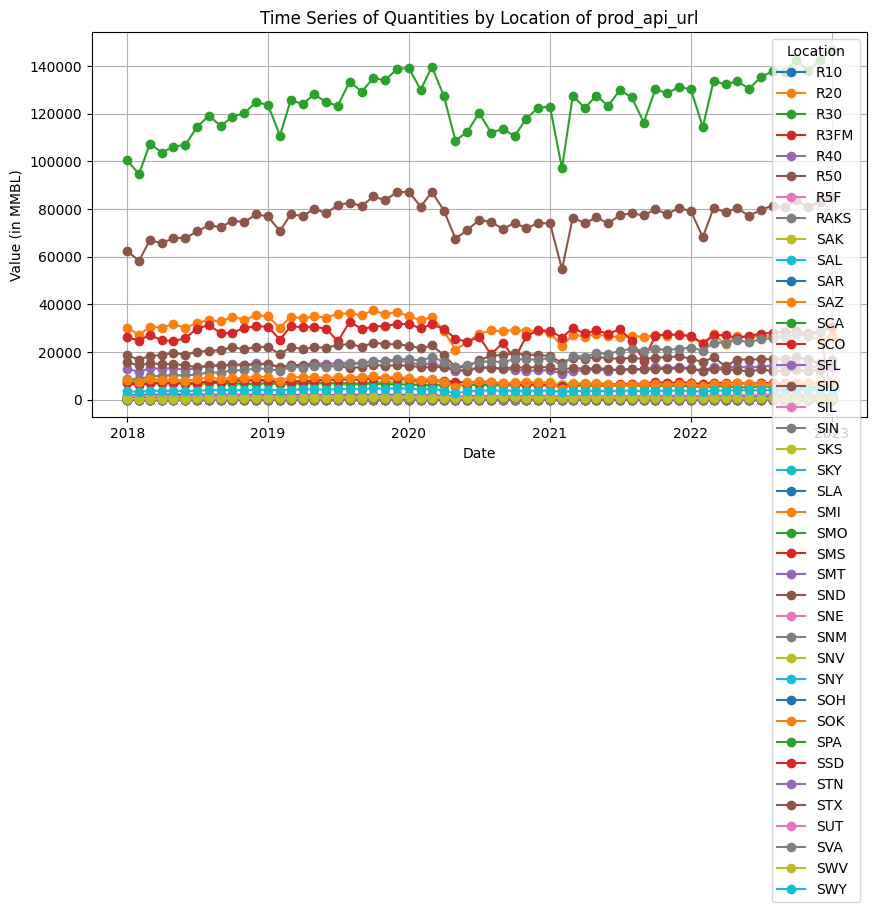

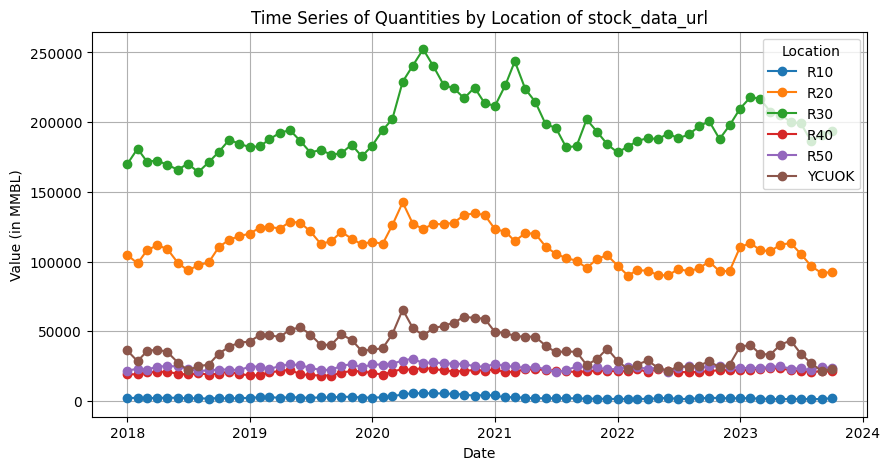

In [163]:
# Convert 'period' to datetime
for key,df in micro_data.items():
  if 'quantity' in df.columns:
    df['period'] = pd.to_datetime(df['period'])
    # Ensure the data is sorted by date
    df.sort_values('period', inplace=True)
    # Plot the time series data
    plt.figure(figsize=(10, 5))
    plt.plot(df['period'], df['quantity'], marker='o')
    plt.title(f'Time Series of {key}')
    plt.xlabel('Date')
    plt.ylabel(f'Quantity ')
    plt.grid(True)
    plt.show()
  elif 'value' in df.columns:
    # Convert 'period' to datetime
    df['period'] = pd.to_datetime(df['period'])
    df.sort_values('period', inplace=True)
    pivot_df = df.pivot_table(index='period', columns='duoarea', values='value')
    # Plot the time series data
    plt.figure(figsize=(10, 5))
    # Loop through the columns (locations) to plot them
    for location in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[location], marker='o', label=location)
    # Add title and labels
    plt.title(f'Time Series of Quantities by Location of {key}')
    plt.xlabel('Date')
    plt.ylabel('Value (in MMBL)')

    # Add grid and legend
    plt.grid(True)
    plt.legend(title='Location')

    # Show the plot
    plt.show()

In [164]:
# FRED API key
fred_key = r'484b16395bfa70e86d649f7d42dc1d4b'
# Initiates a session with the FRED datacenter to recieve datasets
fred = Fred(api_key=fred_key);
# Retrieve data from FRED API
fred_data = pd.DataFrame(fred.get_series('WTISPLC'), columns=['WTISPLC']);
price = fred_data['WTISPLC']
price_diff = price.diff()[1:];

<Axes: >

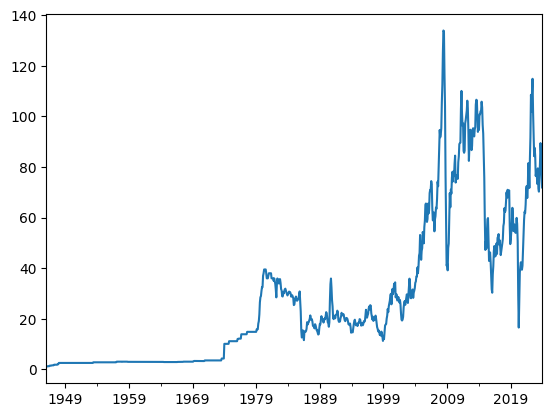

In [165]:
price.plot()

In [166]:
price_ret = price_diff.pct_change().dropna()

<Axes: >

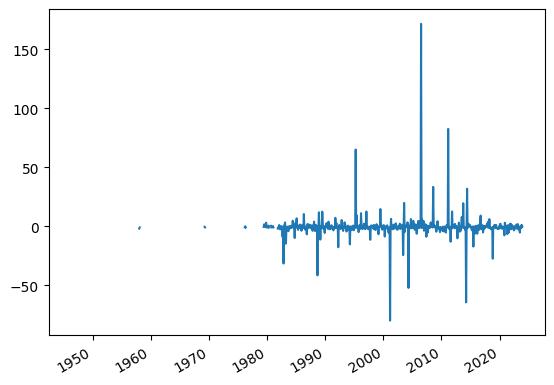

In [167]:
price_ret.plot()

## Financial Data

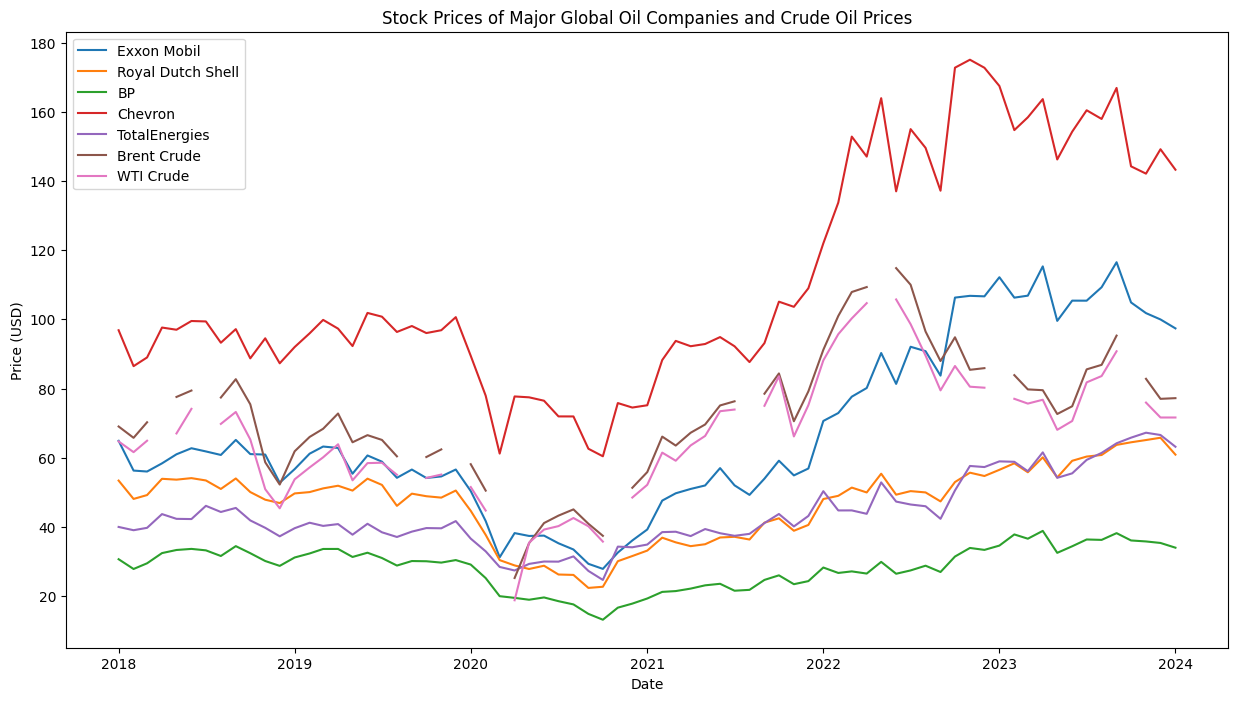

In [168]:
# Define the ticker symbols for major global oil companies and crude oil
tickers = {
    "Exxon Mobil": "XOM",
    "Royal Dutch Shell": "SHEL",
    "BP": "BP",
    "Chevron": "CVX",
    "TotalEnergies": "TTE",
    "Brent Crude": "BZ=F",
    "WTI Crude": "CL=F"
}

# Fetch historical data for each ticker
data = {}
for name, ticker in tickers.items():
    ticker_data = yf.Ticker(ticker)
    data[name] = ticker_data.history(start="2018-01-01", interval="1mo")['Close']

# Convert to DataFrame
df = pd.DataFrame(data)
financial_data = df
# Plotting
plt.figure(figsize=(15, 8))
for name in df.columns:
    plt.plot(df.index, df[name], label=name)

plt.title("Stock Prices of Major Global Oil Companies and Crude Oil Prices")
plt.ylabel("Price (USD)")
plt.xlabel("Date")
plt.legend()
plt.show()

# Step 4

| Indicator Type | Variable Name | Description | Range and Type |
| -------------- | ------------- | ----------- | -------------- |
| macroeconomic  |               |             |                |
| microeconomic  |               |             |                |
| financial      |               |             |

# Step 5


## Clean Outliers


## Clean Bad Data



In [169]:
financial_data.index.duplicated().sum()

0

##Clean Missing Values



#Step 6


As part of sterlization import and stock data will be summaried for each units to store on the date level. We aggregate these records for each source and destination units since they are same.

In [170]:
micro_data.keys()

dict_keys(['import_url', 'prod_api_url', 'stock_data_url'])

In [171]:
micro_data['prod_api_url'].columns

Index(['period', 'duoarea', 'area-name', 'product', 'product-name', 'process',
       'process-name', 'series', 'series-description', 'value', 'units'],
      dtype='object')

In [172]:
micro_data['prod_api_url']['product'].unique()

array(['EPC0', 'EPCANS'], dtype=object)

In [173]:
micro_data['import_url'].gradeId.unique()

array(['MED'], dtype=object)

In [174]:
micro_data['stock_data_url'].columns

Index(['period', 'duoarea', 'area-name', 'product', 'product-name', 'process',
       'process-name', 'series', 'series-description', 'value', 'units'],
      dtype='object')

In [175]:
micro_data['stock_data_url'].units.unique()

array(['MBBL'], dtype=object)

In [176]:
micro_data['import_url'].columns

Index(['period', 'originId', 'originName', 'originType', 'originTypeName',
       'destinationId', 'destinationName', 'destinationType',
       'destinationTypeName', 'gradeId', 'gradeName', 'quantity',
       'quantity-units'],
      dtype='object')

<ipython-input-177-0cc626ea609e>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  micro_data['import_url'].groupby('period').sum().plot()


<Axes: xlabel='period'>

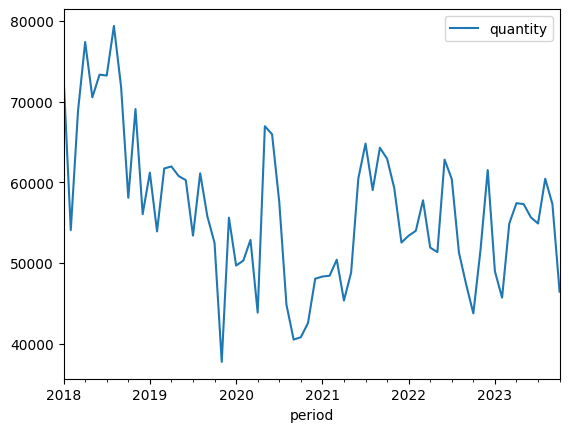

In [177]:
micro_data['import_url'].groupby('period').sum().plot()

In [178]:
micro_data['stock_data_url'].groupby('period').sum().sort_index().tail()

<ipython-input-178-10d44475ac64>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  micro_data['stock_data_url'].groupby('period').sum().sort_index().tail()


,value
period,
2023-06-01,403408
2023-07-01,385143
2023-08-01,354593
2023-09-01,351586
2023-10-01,356106


In [189]:
oil_stock_data = micro_data['stock_data_url'].groupby('period').sum()
oil_stock_data.rename({'value':'oil_stock'}, axis =1 ,inplace=True)
oil_prod_data = micro_data['prod_api_url'].groupby('period').sum()
oil_prod_data.rename({'value':'oil_prod'}, axis =1,inplace=True )


<ipython-input-189-99e916696f89>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  oil_stock_data = micro_data['stock_data_url'].groupby('period').sum()
<ipython-input-189-99e916696f89>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  oil_prod_data = micro_data['prod_api_url'].groupby('period').sum()


<Axes: xlabel='period'>

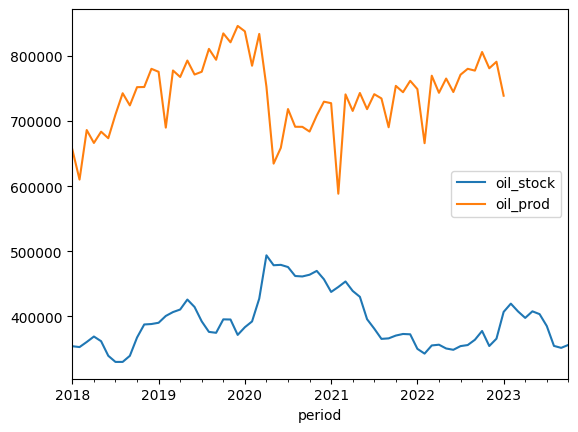

In [190]:
oil_stock_data.join(oil_prod_data).plot()

In [191]:
micro_data_df = oil_stock_data.join(oil_prod_data)

In [196]:
macro_data_df = pd.concat(macro_data.values())

In [198]:
mm_data = macro_data_df.join(micro_data_df, how = 'inner')

In [205]:
mm_data_clean= mm_data.fillna(method='ffill').dropna()

In [209]:
mm_data_clean[mm_data_clean.index.duplicated()]

,STEO.PAPR_NONOPEC.M,STEO.COPR_OPEC.M,oil_stock,oil_prod
period,,,,
2018-02-01,63.772616,29.986,352806,610083.0
2018-03-01,64.250262,29.839,360609,686209.0
2018-04-01,64.445229,29.778,369013,666370.0
2018-05-01,64.568356,29.658,361815,683658.0
2018-06-01,65.232025,29.689,339393,673643.0
...,...,...,...,...
2023-06-01,69.826691,27.135,403408,738924.0
2023-07-01,70.100750,26.290,385143,738924.0
2023-08-01,69.915890,26.085,354593,738924.0


In [212]:
macro_data_df.loc['2023-10-01']

,STEO.PAPR_NONOPEC.M,STEO.COPR_OPEC.M
period,,
2023-10-01,70.628389,NaN
2023-10-01,NaN,26.625


In [210]:
mm_data_clean.loc['2023-10-01']

,STEO.PAPR_NONOPEC.M,STEO.COPR_OPEC.M,oil_stock,oil_prod
period,,,,
2023-10-01,70.628389,26.745,356106,738924.0
2023-10-01,70.628389,26.625,356106,738924.0


<Axes: xlabel='period'>

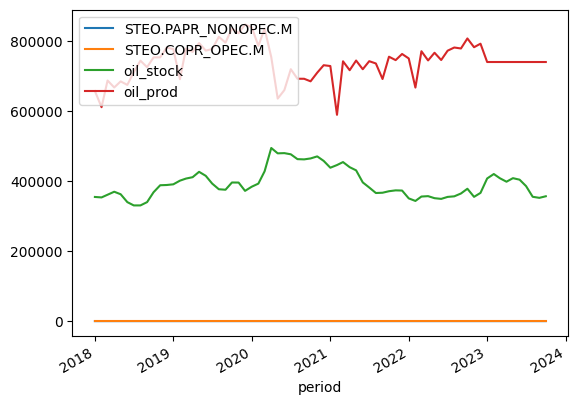

In [202]:
mm_data.fillna(method='ffill').dropna().plot()

In [184]:
micro_data['import_url'].gradeId.unique()

array(['MED'], dtype=object)

In [185]:
macro_data.keys()

dict_keys(['PAPR_NONOPEC', 'COPR_OPEC'])

<Axes: xlabel='period'>

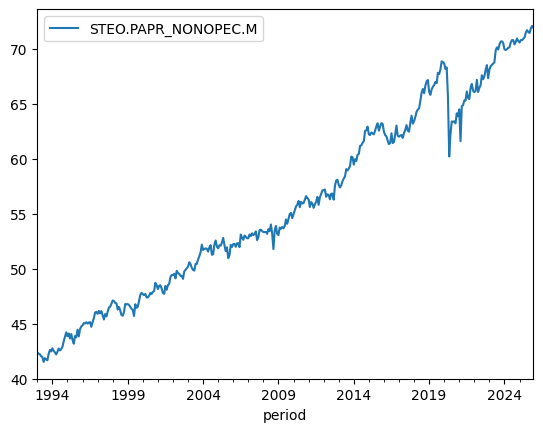

In [186]:
macro_data['PAPR_NONOPEC'].plot()

<ipython-input-187-9ba5fb8d23a5>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  macro_data['COPR_OPEC'].join(micro_data['stock_data_url'].groupby('period').sum(), how='inner')['STEO.COPR_OPEC.M'].plot()


<Axes: xlabel='period'>

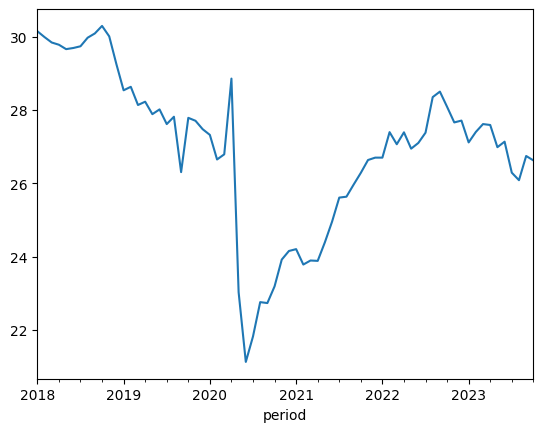

In [187]:
macro_data['COPR_OPEC'].join(micro_data['stock_data_url'].groupby('period').sum(), how='inner')['STEO.COPR_OPEC.M'].plot()

<Axes: xlabel='period'>

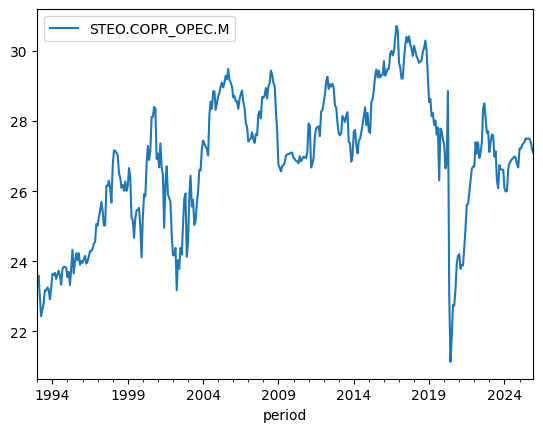

In [188]:
macro_data['COPR_OPEC'].plot()

## Sterlized Version of Data

#Step 7



## Distributional Plots

##Time Series Plots

## Multivariate Plot

#Step 8



## Oil Data vs Other Data Types

## Oil Returns Distribution

## Oil returns autocorrelation

## Oil Prices stylized facts

#Step 9

## Probabilistic Graphic Models. Belief networks Vs Markov networks.

## Parameter learning vs Structure learning.

## Markov chains and Markov blankets.

# Step 10

## Algorithm1: Inferred Causality


### Implementation A

### Implementation B

### Implementation C
